In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from uq360.algorithms.infinitesimal_jackknife.infinitesimal_jackknife import InfinitesimalJackknife
from uq360.utils.logistic_regression import LogisticRegression, get_num_train, logistic_predictions
%matplotlib inline

In this notebook, we will illustrate infinitesimal jackknife (IJ) for logistic regression. Let's define the model.

The only non-standard components of the model defined above are the functions compute_hessian
and compute_dparams_dweights. Both of these functions are required for IJ computation.
Models that aim to use IJ need to implement these two functions.

Let us now use the IJ approximation to jackknife to get confidence intervals.

## Fit the model to simulated data

In [3]:
lr = LogisticRegression()
# generate simulated data
inputs, targets, test_inputs, test_targets = lr.synthetic_lr_data()
init_params = 1e-1 * np.random.randn(inputs.shape[1])

# Standard MLE model fit
weights_one = np.ones([1, get_num_train(inputs)])
params_one = lr.fit(weights_one, init_params, inputs, targets)
print("Maximum Likelihood Solution's Test Accuracy {0}".format(
lr.get_test_acc(params_one, test_targets, test_inputs)))
H = lr.compute_hessian(params_one, weights_one, inputs, targets)
J = lr.compute_jacobian(params_one, weights_one, inputs, targets)

# Approximate Jackknife
config = {"alpha": 0.01, "resampling_strategy": 'jackknife'}
ij = InfinitesimalJackknife(params_one, J, H, config)

Initial loss: 7669.8815912718555
         Current function value: 4186.835118
         Iterations: 27
         Function evaluations: 43
         Gradient evaluations: 43
Trained loss: 4186.835117603553
Maximum Likelihood Solution's Test Accuracy 0.8009999999999999


## Is IJ an accurate approximation to Exact Jackknife?

First we will verify that infinitesimal jackknife is a good approximation to exact jackknife.
We will do so by running exact jackknife on a subset of the data and comparing with IJ.

Mean Absolute Deviation between approximate and exact jackknife:  4.7273335839204124e-07


Text(0, 0.5, 'IJ')

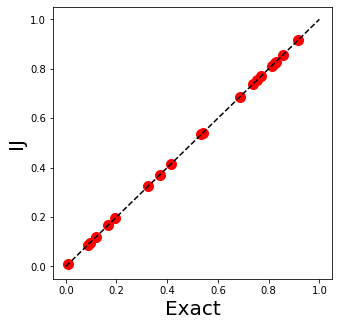

In [4]:
# compare approximate with exact jackknife for a few points
weights = np.ones_like(weights_one)
y_pred_exact = np.zeros([20, 1])
y_pred_approx = np.zeros([20, 1])
y_pred_mle = np.zeros([20, 1])
for i in np.arange(20):
    weights[0, i] = 0
    params = lr.fit(weights, params_one, inputs, targets, verbose=False)
    lr.set_parameters(params)
    y_pred_exact[i] = lr.predict(inputs[i])
    ij_params = ij.ij(weights.squeeze())
    lr.set_parameters(ij_params)
    y_pred_approx[i] = lr.predict(inputs[i])
    lr.set_parameters(params_one)
    y_pred_mle[i] = lr.predict(inputs[i])
    weights[0, i] = 1

print("Mean Absolute Deviation between approximate and exact jackknife: ",
      np.mean(np.abs(y_pred_approx - y_pred_exact)))
assert np.allclose(y_pred_exact, y_pred_approx, atol=1e-6, rtol=1e-3)

plt.figure(figsize=(5,5))
plt.plot(y_pred_exact, y_pred_approx, 'ro', ms=10)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Exact", fontsize=20)
plt.ylabel("IJ", fontsize=20)

As we can see, there is strong agreement between exact and approximate (IJ) jackknife.

## Predictive uncertainties
Next, we will use IJ to get predictive uncertainties.

In [5]:
y_pred, y_lb, y_ub = ij.predict(test_inputs, lr)

In [6]:
np.set_printoptions(precision=3)
# let's look at some of the predictions; we will visualize 20 data points with the  largest uncertainties.
pi = y_ub - y_lb
idx = np.argsort(-pi.ravel())
# plt.plot(y_pred[:20], np.arange(20), 'ro', ms=1)
for i, v in enumerate(idx[:20]):
    print ("{0}, {1}, {2}".format(y_lb[v], y_pred[v], y_ub[v]))
    

[0.516], [0.517], [0.519]
[0.54], [0.541], [0.543]
[0.382], [0.383], [0.385]
[0.487], [0.488], [0.489]
[0.496], [0.497], [0.499]
[0.436], [0.437], [0.438]
[0.461], [0.463], [0.464]
[0.62], [0.621], [0.622]
[0.514], [0.515], [0.516]
[0.646], [0.647], [0.648]
[0.695], [0.696], [0.698]
[0.538], [0.539], [0.54]
[0.402], [0.403], [0.404]
[0.605], [0.606], [0.607]
[0.535], [0.536], [0.537]
[0.593], [0.594], [0.595]
[0.49], [0.491], [0.492]
[0.516], [0.518], [0.519]
[0.418], [0.419], [0.421]
[0.58], [0.581], [0.582]
